# Spring 2020 - MFE 230E - PS3
Note: Please email mfe230e@gmail.com if there are any corrections you would like to make to these solutions.

**Notes:** <br>
- This notebook only presents the code. Cf. the pdf for explanations, derivations, and answers.
- The following uses the lib files that is used in the Python Labs. <br>
- If running the cell block right below gives the following warning: ``FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated...``, then this is an issue with the ``scipy`` library. Please update this library by running the following code in your Jupyter notebook:
``!pip install --upgrade scipy``

In [2]:
from lib import *

set_stuff()

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


## Problem 1

(a)

In [3]:
### From lab2_2020
def simulate_arma(ar=[], ma=[], nsample=100, burnin=0, paths=1):
    """Simulate ARMA data
       Assumption: White noise shocks are Gaussian.
    """
    ### numpy arrays are reversed for easier indexing:
    ar, ma = np.array(ar[::-1]), np.array(ma[::-1])
    ### Orders (does not include zero lag)
    p, q = len(ar), len(ma)
    max_order = max(p,q)
    
    ### Total number of sample size
    Nsim = nsample + burnin
    ### "Standard" Guassian shocks: Normal(0,1)
    eps = np.random.randn(paths, Nsim)
    ### Initialize t < 0 with zeros
    eps = np.concatenate((np.zeros((paths, max_order)), eps), axis=1)
    y = np.zeros((paths, Nsim + max_order))
    
    ### Loop to construct the ARMA processes recursively.
    for tt in range(max_order, Nsim + max_order):
        y[:, tt] = np.sum(y[:, tt-p:tt]*ar, axis=1) + np.sum(eps[:,tt-q:tt]*ma, axis=1) + eps[:,tt]
    
    ### Drop initial zeros and burnin and transpose for plotting.
    y = y[:, max_order + burnin:].T
    return y

In [4]:
### Seed the random number generator
np.random.seed(1)

### Simulate ARMA(1,1)
phi1_model1 = 0.8
theta1_model1 = 0.7
y_arma11_model1 = simulate_arma(ar=[phi1_model1],ma=[theta1_model1], burnin=100, nsample=1000,paths=10000)

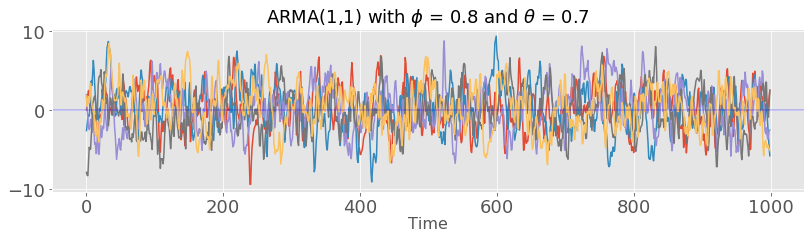

In [5]:
### Plot a few samples to check
f = plt.figure(figsize=(12,3))
n = 5
for i in range(n):
    plt.plot(y_arma11_model1[:,i])
plt.xlabel('Time', fontsize=16)
plt.title('ARMA($1$,$1$)' + ' with $\phi$ = ' + str(phi1_model1) + r' and $\theta$ = ' + str(theta1_model1), fontsize=18)
plt.axhline(y=0, linewidth=0.4)
plt.show()

In [6]:
### From lab2_2020
def calc_ols(y, x, addcon=True):
    """Calculate OLS coefficients from scratch"""
    Nobs = y.shape[0]
    Y = np.matrix(y).T # Force it to be a matrix
    if addcon:
        X = np.c_[np.ones((Nobs,1)), x] # append the [Nobs x 1] columns of ones.
    else:
        #X = x
        X=np.matrix(x).T # Force it to be a matrix
    XX = np.dot(X.T, X) # Construct sample average of E[X'X]
    Xy = np.dot(X.T, y) # Construct sample average of E[X'Y]
    beta_hat = np.linalg.solve(XX, Xy) # algebraic solution for OLS. beta_hat = (E[X'X]^-1)*(E[X'Y])
    resids = y - np.dot(X, beta_hat) # residual eps_hat = y - beta_hat*X 
    return beta_hat, resids, X

In [7]:
### Estimate coefficient by OLS for each simulation
Nsims = 10000
Nobs = 1000
ols_coefs = np.empty((2,Nsims))
ols_resid = np.empty((Nobs-1,Nsims))

for ss in range(Nsims): 

    ### Run OLS (with constant)
    beta_hat, resids, _ = calc_ols(y_arma11_model1[1:,ss],y_arma11_model1[:-1,ss],addcon=True)
        
    ### Store regression estimates in [K x Nsims] numpy array
    ols_coefs[:,ss] = beta_hat
    ols_resid[:,ss] = resids

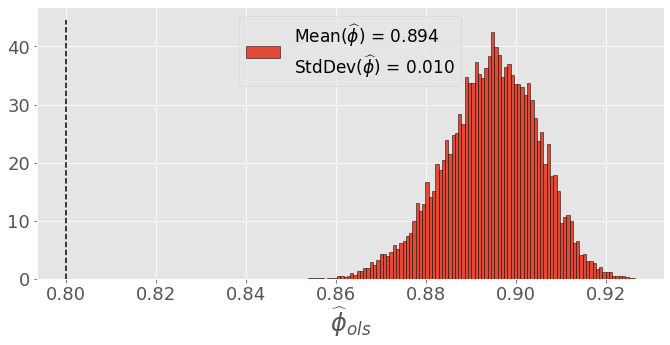

In [8]:
### Plot histogram of OLS coefficients
f = plt.figure(figsize=(10,5))
ols_phi_label = 'Mean$(\widehat\\phi)$ = {:.3f}\nStdDev$(\widehat\\phi)$ = {:.3f}'\
                     .format(np.mean(ols_coefs[1,:]),np.std(ols_coefs[1,:])) 
ols_xlabel = '$\widehat\\phi_{ols}$'
plt.hist(ols_coefs[1,:],bins=100, density=True, edgecolor = "black", label=ols_phi_label)
plt.xlabel(ols_xlabel, fontsize=24)
ymin, ymax = plt.ylim()
asy_mean = phi1_model1
plt.plot((asy_mean, asy_mean), (ymin, ymax), 'k--')
plt.legend(fontsize=17)
plt.show()

(b)

In [9]:
### From lab2_2020
def lag_mat(y,nlags, fill_vals=np.nan):
    """Create a matrix of lags of a given vector"""
    y_lags = np.empty((y.shape[0], nlags+1)) 
    y_lags.fill(fill_vals)
    
    ### Include 0 lag
    for lag in range(nlags + 1):
        y_lags[lag:, lag] = np.roll(y, shift=lag)[lag:] 
    return y_lags

### ACF, PACF by OLS
def calc_acf_lag_ols(y_lags, lag):
    """ACF for a given lag (OLS)"""
    if lag==0: 
        return 1.
    lhs = y_lags[lag:, 0]
    rhs = y_lags[lag:, lag:lag+1]
    beta_hat, _,_ = calc_ols(y=lhs, x=rhs, addcon=True)
    return beta_hat[-1]
def calc_pacf_lag_ols(y_lags, lag):
    """PACF for a given lag (OLS)"""
    if lag==0: 
        return 1.
    lhs = y_lags[lag:, 0]
    ### need y_lags[lag:, 1:lag+1] instead of y_lags[lag:,lag:lag+1] (unlike "calc_acf_lag_ols")
    rhs = y_lags[lag:, 1:lag+1] 
    beta_hat, _,_ = calc_ols(y=lhs, x=rhs, addcon=True)
    return beta_hat[-1]

### ACF and PACF for all lags
def calc_acf_ols(y, nlags):
    """ACF for multiple lags"""
    y_lags = lag_mat(y,nlags)
    acf_list = [calc_acf_lag_ols(y_lags,lag) for lag in range(nlags + 1)]
    return np.array(acf_list)
def calc_pacf_ols(y, nlags):
    """PACF for multiple lags"""
    y_lags = lag_mat(y,nlags)
    pacf_list = [calc_pacf_lag_ols(y_lags,lag) for lag in range(nlags + 1)]
    return np.array(pacf_list)

In [10]:
### Compute ACFs for each simulation
Nsims = 10000
Nlags = 15
acfs = np.empty((Nlags+1,Nsims))
pacfs = np.empty((Nlags+1,Nsims))

for ss in range(Nsims): 

    ### Run OLS (with constant)
    _acfs = calc_acf_ols(ols_resid[:,ss],nlags=15)
    _pacfs = calc_pacf_ols(ols_resid[:,ss],nlags=15)
        
    ### Store regression estimates in [Nsims x K] numpy array
    acfs[:,ss] = _acfs
    pacfs[:,ss] = _pacfs

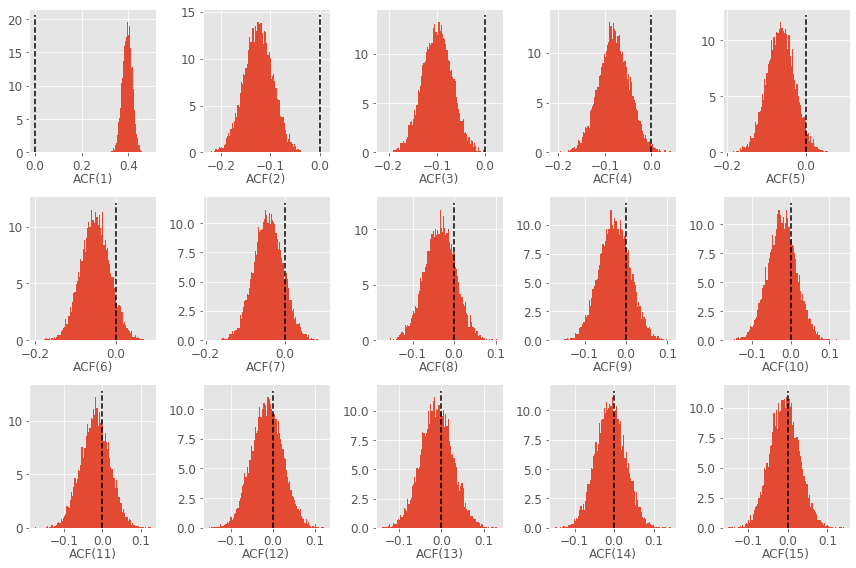

In [11]:
f,a = plt.subplots(nrows=3, ncols=5, figsize=(12,8))

for i in range(0,Nlags):
    a[i//5,i%5].hist(acfs[i+1,:],bins=100, density=True)
    ymin, ymax = a[i//5,i%5].get_ylim()
    a[i//5,i%5].plot((0,0), (ymin, ymax), 'k--')
    a[i//5,i%5].set_xlabel('ACF('+str(i+1)+')', fontsize = 12)
    a[i//5,i%5].tick_params(labelsize=12)
f.tight_layout()

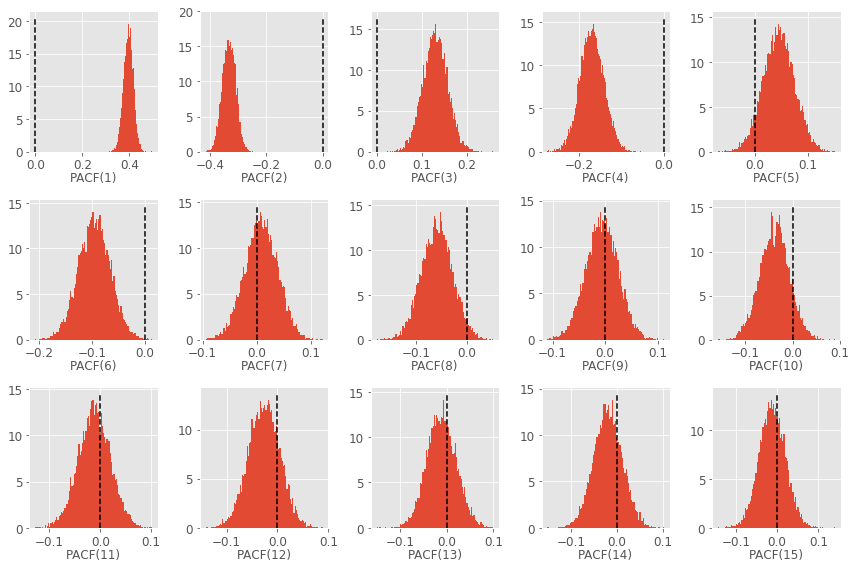

In [12]:
f,a = plt.subplots(nrows=3, ncols=5, figsize=(12,8))

for i in range(0,Nlags):
    a[i//5,i%5].hist(pacfs[i+1,:],bins=100, density=True)
    ymin, ymax = a[i//5,i%5].get_ylim()
    a[i//5,i%5].plot((0,0), (ymin, ymax), 'k--')
    a[i//5,i%5].set_xlabel('PACF('+str(i+1)+')', fontsize = 12)
    a[i//5,i%5].tick_params(labelsize=12)
f.tight_layout()

(c) Use $x_{t-1}$ as IV for $x_t$ in $x_{t+1} = \phi x_t + e_{t+1}$.

In [13]:
### From lab2_2020
def calc_iv(y, x, z, addcon=True):
    """Calculate IV coefficients from scratch"""
    Nobs = y.shape[0]
    Y = np.matrix(y).T # Force it to be a matrix
    if addcon:
        Z = np.c_[np.ones((Nobs,1)), z] # append the [Nobs x 1] columns of ones.
        X = np.c_[np.ones((Nobs,1)), x] # append the [Nobs x 1] columns of ones.
    else:
        #X = x
        Z=np.matrix(z).T # Force it to be a matrix
        X = np.matrix(x).T # Force it to be a matrix
    ZX = np.dot(Z.T, X) # Construct sample average of E[X'X]
    Zy = np.dot(Z.T, y) # Construct sample average of E[X'Y]
    beta_hat = np.linalg.solve(ZX, Zy) # algebraic solution for OLS. beta_hat = (E[X'X]^-1)*(E[X'Y])
    resids = y - np.dot(X, beta_hat) # residual eps_hat = y - beta_hat*X 
    return beta_hat, resids, X

In [14]:
### Estimate coefficient via IV for each simulation
Nsims = 10000
Nobs = 1000
iv_coefs = np.empty((2,Nsims))
iv_resid = np.empty((Nobs-2,Nsims))

for ss in range(Nsims): 

    ### Run OLS (with constant)
    beta_hat, resids, _ = calc_iv(y_arma11_model1[2:,ss],y_arma11_model1[1:-1,ss],y_arma11_model1[:-2,ss],addcon=True)
        
    ### Store regression estimates in [K x Nsims] numpy array
    iv_coefs[:,ss] = beta_hat
    iv_resid[:,ss] = resids

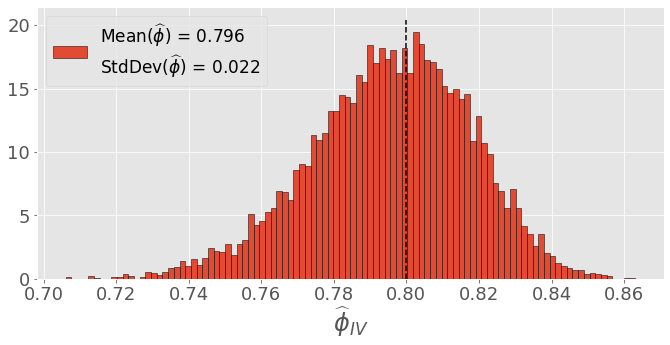

In [15]:
### Plot histogram of IV coefficients
f = plt.figure(figsize=(10,5))
iv_phi_label = 'Mean$(\widehat\\phi)$ = {:.3f}\nStdDev$(\widehat\\phi)$ = {:.3f}'\
                     .format(np.mean(iv_coefs[1,:]),np.std(iv_coefs[1,:])) 
iv_xlabel = '$\widehat\\phi_{IV}$'
plt.hist(iv_coefs[1,:],bins=100, density=True, edgecolor = "black", label=iv_phi_label)
plt.xlabel(iv_xlabel, fontsize=24)
ymin, ymax = plt.ylim()
asy_mean = phi1_model1
plt.plot((asy_mean, asy_mean), (ymin, ymax), 'k--')
plt.legend(fontsize=17)
plt.show()

## Problem 2

(a)
$\begin{align*}
(1-\lambda_1 L)(1-\lambda_2 L)(1-\lambda_3 L)x_{t+1} = e_{t+1}
&\Rightarrow (1 - 2.65L + 2.335 L^2 - 0.684 L^3) x_{t+1} = e_{t+1} \\
&\Rightarrow x_{t+1} = 2.65 x_t - 2.335 x_{t-1} + 0.684 x_{t-2} + e_{t+1}
\end{align*}
$

In [16]:
### Seed the random number generator
np.random.seed(1)

### Simulate ARMA(1,1)
phi1_model2 = 2.65
phi2_model2 = -2.335
phi3_model2 = 0.684
y_ar3_model2 = simulate_arma(ar=[phi1_model2,phi2_model2,phi3_model2],burnin=100,nsample=1000,paths=10000)

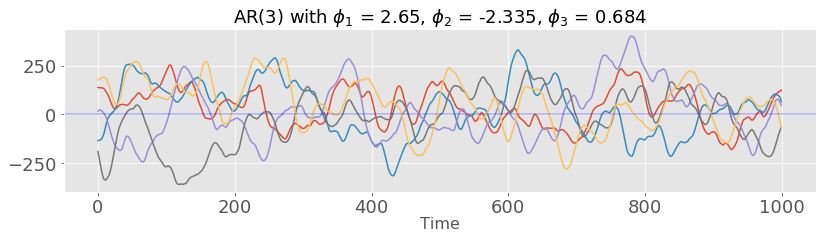

In [38]:
### Plot a few samples to check
f = plt.figure(figsize=(12,3))
n = 5
for i in range(n):
    plt.plot(y_ar3_model2[:,i])
plt.xlabel('Time', fontsize=16)
plt.title('AR($3$)' + ' with $\phi_1$ = ' + str(phi1_model2) \
          + ', $\phi_2$ = ' + str(phi2_model2) \
          + ', $\phi_3$ = ' + str(phi3_model2), fontsize=18)
plt.axhline(y=0, linewidth=0.4)
plt.show()

In [18]:
### Estimate coefficient by OLS for each simulation
Nsims = 10000
Nobs = 1000
ols_coefs_model2_AR1 = np.empty((2,Nsims))
ols_resid_model2_AR1 = np.empty((Nobs-1,Nsims))

for ss in range(Nsims): 

    ### Run OLS (with constant)
    beta_hat, resids, _ = calc_ols(y_ar3_model2[1:,ss],np.c_[y_ar3_model2[:-1,ss]],addcon=True)
        
    ### Store regression estimates in [K x Nsims] numpy array
    ols_coefs_model2_AR1[:,ss] = beta_hat
    ols_resid_model2_AR1[:,ss] = resids

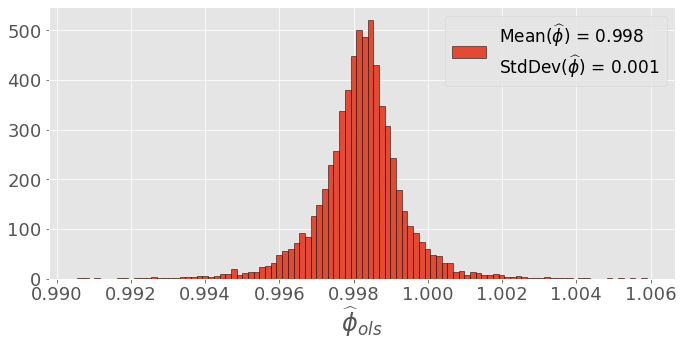

In [19]:
### Plot histogram of OLS coefficients
f = plt.figure(figsize=(10,5))
ols_phi_label = 'Mean$(\widehat\\phi)$ = {:.3f}\nStdDev$(\widehat\\phi)$ = {:.3f}'\
                     .format(np.mean(ols_coefs_model2_AR1[1,:]),np.std(ols_coefs_model2_AR1[1,:])) 
ols_xlabel = '$\widehat\\phi_{ols}$'
plt.hist(ols_coefs_model2_AR1[1,:],bins=100, density=True, edgecolor = "black", label=ols_phi_label)
plt.xlabel(ols_xlabel, fontsize=24)
ymin, ymax = plt.ylim()
asy_mean = phi1_model2
#plt.plot((asy_mean, asy_mean), (ymin, ymax), 'k--')
plt.legend(fontsize=17)
plt.show()

In [20]:
### Compute ACFs and PACFs for each simulation
Nsims = 10000
Nlags = 15
acfs_model2_AR1 = np.empty((Nlags+1,Nsims))
pacfs_model2_AR1 = np.empty((Nlags+1,Nsims))

for ss in range(Nsims): 

    ### Run OLS (with constant)
    _acfs = calc_acf_ols(ols_resid_model2_AR1[:,ss],nlags=15)
    _pacfs = calc_pacf_ols(ols_resid_model2_AR1[:,ss],nlags=15)
        
    ### Store regression estimates in [Nsims x K] numpy array
    acfs_model2_AR1[:,ss] = _acfs
    pacfs_model2_AR1[:,ss] = _pacfs

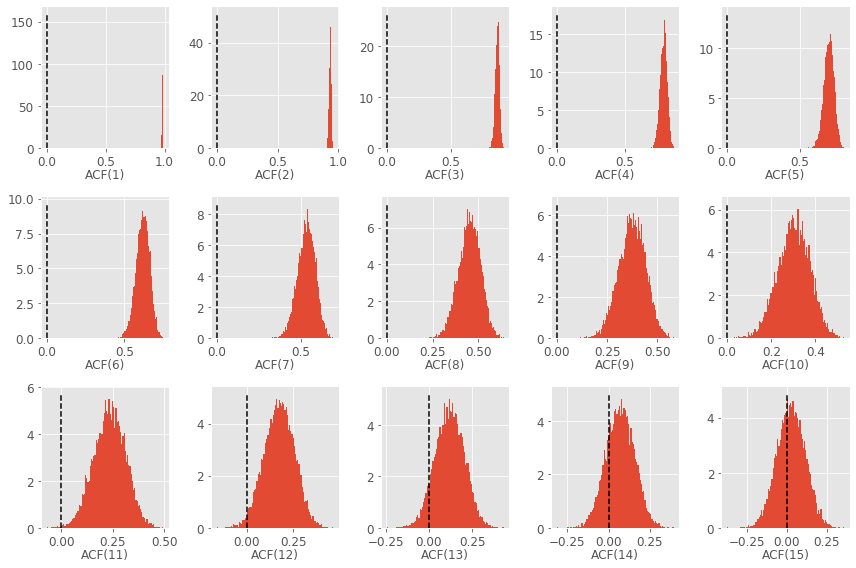

In [21]:
f,a = plt.subplots(nrows=3, ncols=5, figsize=(12,8))

for i in range(0,Nlags):
    a[i//5,i%5].hist(acfs_model2_AR1[i+1,:],bins=100, density=True)
    ymin, ymax = a[i//5,i%5].get_ylim()
    a[i//5,i%5].plot((0,0), (ymin, ymax), 'k--')
    a[i//5,i%5].set_xlabel('ACF('+str(i+1)+')', fontsize = 12)
    a[i//5,i%5].tick_params(labelsize=12)
f.tight_layout()

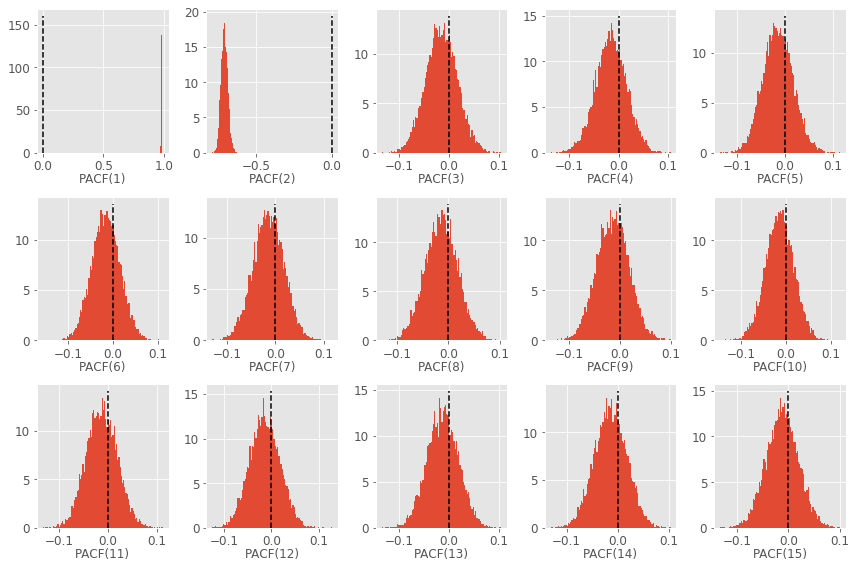

In [22]:
f,a = plt.subplots(nrows=3, ncols=5, figsize=(12,8))

for i in range(0,Nlags):
    a[i//5,i%5].hist(pacfs_model2_AR1[i+1,:],bins=100, density=True)
    ymin, ymax = a[i//5,i%5].get_ylim()
    a[i//5,i%5].plot((0,0), (ymin, ymax), 'k--')
    a[i//5,i%5].set_xlabel('PACF('+str(i+1)+')', fontsize = 12)
    a[i//5,i%5].tick_params(labelsize=12)
f.tight_layout()

(b) AR(2)

In [23]:
### Estimate coefficient by OLS for each simulation
Nsims = 10000
Nobs = 1000
ols_coefs_model2_AR2 = np.empty((3,Nsims))
ols_resid_model2_AR2 = np.empty((Nobs-2,Nsims))

for ss in range(Nsims): 

    ### Run OLS (with constant)
    beta_hat, resids, _ = calc_ols(y_ar3_model2[2:,ss],np.c_[y_ar3_model2[1:-1,ss],y_ar3_model2[:-2,ss]],addcon=True)
        
    ### Store regression estimates in [K x Nsims] numpy array
    ols_coefs_model2_AR2[:,ss] = beta_hat
    ols_resid_model2_AR2[:,ss] = resids

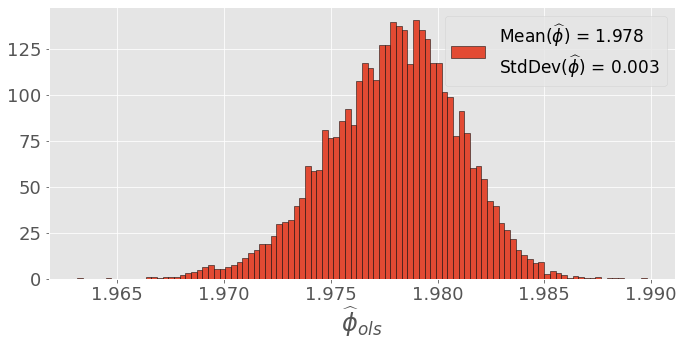

In [24]:
### Plot histogram of OLS coefficients
f = plt.figure(figsize=(10,5))
ols_phi_label = 'Mean$(\widehat\\phi)$ = {:.3f}\nStdDev$(\widehat\\phi)$ = {:.3f}'\
                     .format(np.mean(ols_coefs_model2_AR2[1,:]),np.std(ols_coefs_model2_AR2[1,:])) 
ols_xlabel = '$\widehat\\phi_{ols}$'
plt.hist(ols_coefs_model2_AR2[1,:],bins=100, density=True, edgecolor = "black", label=ols_phi_label)
plt.xlabel(ols_xlabel, fontsize=24)
ymin, ymax = plt.ylim()
asy_mean = phi1_model2
#plt.plot((asy_mean, asy_mean), (ymin, ymax), 'k--')
plt.legend(fontsize=17)
plt.show()

In [25]:
### Compute ACFs and PACFs for each simulation
Nsims = 10000
Nlags = 15
acfs_model2_AR2 = np.empty((Nlags+1,Nsims))
pacfs_model2_AR2 = np.empty((Nlags+1,Nsims))

for ss in range(Nsims): 

    ### Run OLS (with constant)
    _acfs = calc_acf_ols(ols_resid_model2_AR2[:,ss],nlags=15)
    _pacfs = calc_pacf_ols(ols_resid_model2_AR2[:,ss],nlags=15)
        
    ### Store regression estimates in [Nsims x K] numpy array
    acfs_model2_AR2[:,ss] = _acfs
    pacfs_model2_AR2[:,ss] = _pacfs

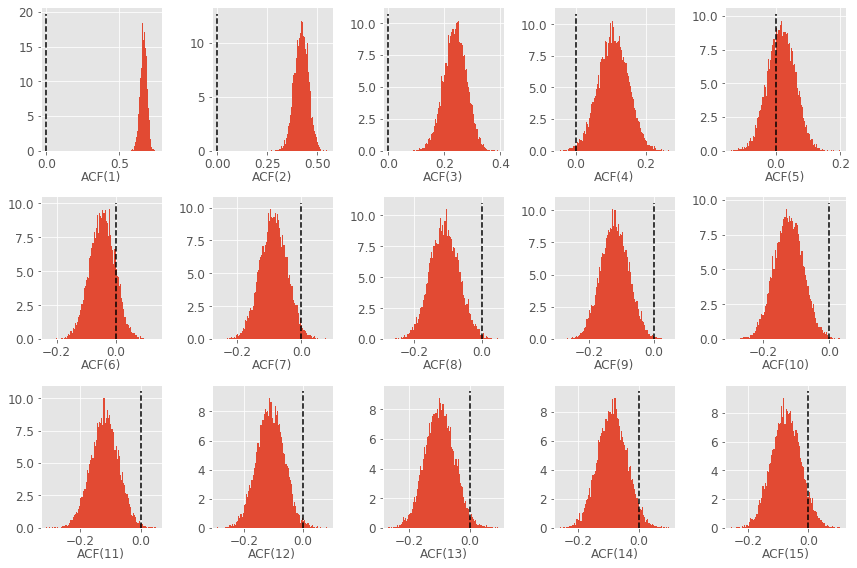

In [26]:
f,a = plt.subplots(nrows=3, ncols=5, figsize=(12,8))

for i in range(0,Nlags):
    a[i//5,i%5].hist(acfs_model2_AR2[i+1,:],bins=100, density=True)
    ymin, ymax = a[i//5,i%5].get_ylim()
    a[i//5,i%5].plot((0,0), (ymin, ymax), 'k--')
    a[i//5,i%5].set_xlabel('ACF('+str(i+1)+')', fontsize = 12)
    a[i//5,i%5].tick_params(labelsize=12)
f.tight_layout()

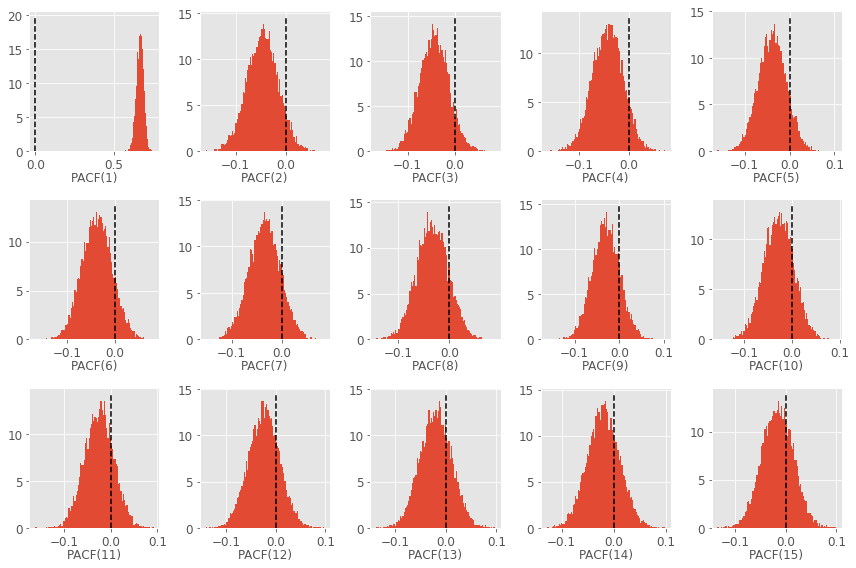

In [27]:
f,a = plt.subplots(nrows=3, ncols=5, figsize=(12,8))

for i in range(0,Nlags):
    a[i//5,i%5].hist(pacfs_model2_AR2[i+1,:],bins=100, density=True)
    ymin, ymax = a[i//5,i%5].get_ylim()
    a[i//5,i%5].plot((0,0), (ymin, ymax), 'k--')
    a[i//5,i%5].set_xlabel('PACF('+str(i+1)+')', fontsize = 12)
    a[i//5,i%5].tick_params(labelsize=12)
f.tight_layout()

(b) AR(3)

In [28]:
### Estimate coefficient by OLS for each simulation
Nsims = 10000
Nobs = 1000
ols_coefs_model2_AR3 = np.empty((4,Nsims))
ols_resid_model2_AR3 = np.empty((Nobs-3,Nsims))

for ss in range(Nsims): 

    ### Run OLS (with constant)
    beta_hat, resids, _ = calc_ols(y_ar3_model2[3:,ss],
                                   np.c_[y_ar3_model2[2:-1,ss],
                                         y_ar3_model2[1:-2,ss],
                                        y_ar3_model2[:-3,ss]],addcon=True)
        
    ### Store regression estimates in [K x Nsims] numpy array
    ols_coefs_model2_AR3[:,ss] = beta_hat
    ols_resid_model2_AR3[:,ss] = resids

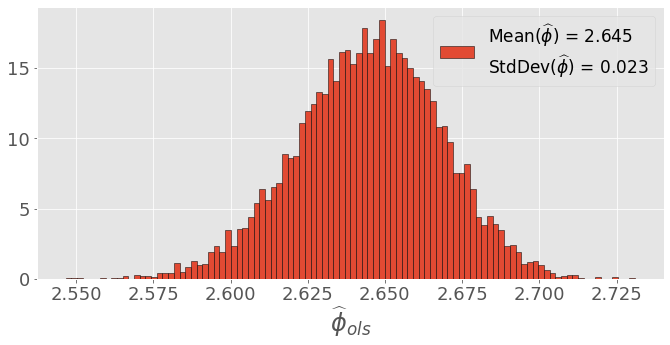

In [29]:
### Plot histogram of OLS coefficients
f = plt.figure(figsize=(10,5))
ols_phi_label = 'Mean$(\widehat\\phi)$ = {:.3f}\nStdDev$(\widehat\\phi)$ = {:.3f}'\
                     .format(np.mean(ols_coefs_model2_AR3[1,:]),np.std(ols_coefs_model2_AR3[1,:])) 
ols_xlabel = '$\widehat\\phi_{ols}$'
plt.hist(ols_coefs_model2_AR3[1,:],bins=100, density=True, edgecolor = "black", label=ols_phi_label)
plt.xlabel(ols_xlabel, fontsize=24)
ymin, ymax = plt.ylim()
asy_mean = phi1_model2
#plt.plot((asy_mean, asy_mean), (ymin, ymax), 'k--')
plt.legend(fontsize=17)
plt.show()

In [30]:
### Compute ACFs and PACFs for each simulation
Nsims = 10000
Nlags = 15
acfs_model2_AR3 = np.empty((Nlags+1,Nsims))
pacfs_model2_AR3 = np.empty((Nlags+1,Nsims))

for ss in range(Nsims): 

    ### Run OLS (with constant)
    _acfs = calc_acf_ols(ols_resid_model2_AR3[:,ss],nlags=15)
    _pacfs = calc_pacf_ols(ols_resid_model2_AR3[:,ss],nlags=15)
        
    ### Store regression estimates in [Nsims x K] numpy array
    acfs_model2_AR3[:,ss] = _acfs
    pacfs_model2_AR3[:,ss] = _pacfs

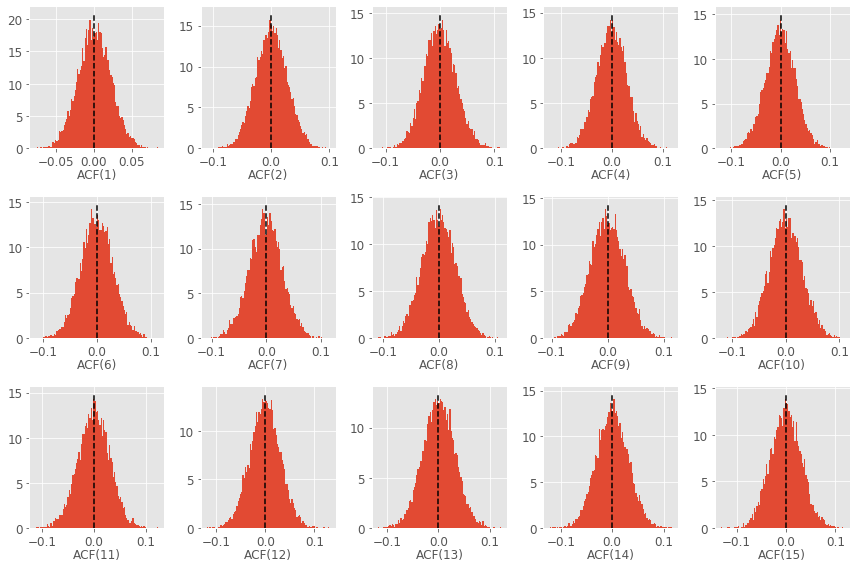

In [31]:
f,a = plt.subplots(nrows=3, ncols=5, figsize=(12,8))

for i in range(0,Nlags):
    a[i//5,i%5].hist(acfs_model2_AR3[i+1,:],bins=100, density=True)
    ymin, ymax = a[i//5,i%5].get_ylim()
    a[i//5,i%5].plot((0,0), (ymin, ymax), 'k--')
    a[i//5,i%5].set_xlabel('ACF('+str(i+1)+')', fontsize = 12)
    a[i//5,i%5].tick_params(labelsize=12)
f.tight_layout()

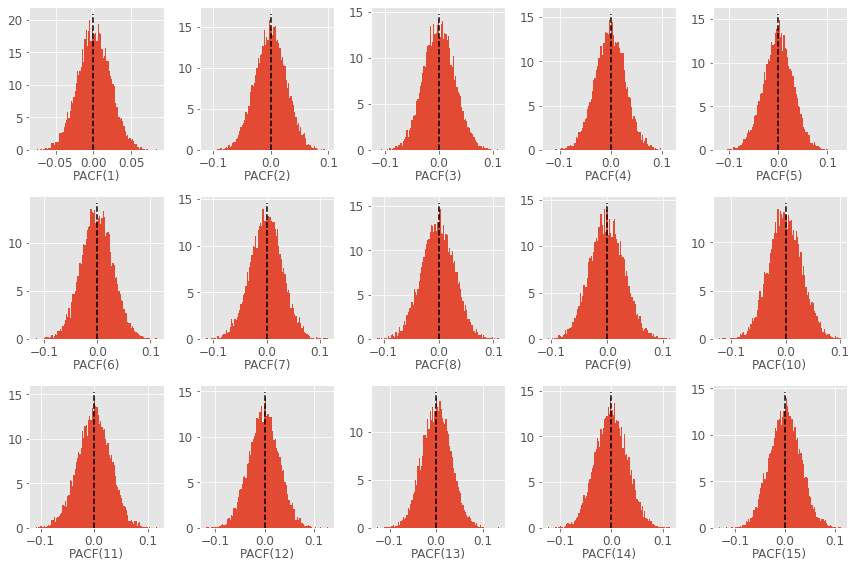

In [32]:
f,a = plt.subplots(nrows=3, ncols=5, figsize=(12,8))

for i in range(0,Nlags):
    a[i//5,i%5].hist(pacfs_model2_AR3[i+1,:],bins=100, density=True)
    ymin, ymax = a[i//5,i%5].get_ylim()
    a[i//5,i%5].plot((0,0), (ymin, ymax), 'k--')
    a[i//5,i%5].set_xlabel('PACF('+str(i+1)+')', fontsize = 12)
    a[i//5,i%5].tick_params(labelsize=12)
f.tight_layout()

(b) AR(4)

In [33]:
### Estimate coefficient by OLS for each simulation
Nsims = 10000
Nobs = 1000
ols_coefs_model2_AR4 = np.empty((5,Nsims))
ols_resid_model2_AR4 = np.empty((Nobs-4,Nsims))

for ss in range(Nsims): 

    ### Run OLS (with constant)
    beta_hat, resids, _ = calc_ols(y_ar3_model2[4:,ss],
                                   np.c_[y_ar3_model2[3:-1,ss],
                                         y_ar3_model2[2:-2,ss],
                                         y_ar3_model2[1:-3,ss],
                                         y_ar3_model2[:-4,ss]],addcon=True)
        
    ### Store regression estimates in [K x Nsims] numpy array
    ols_coefs_model2_AR4[:,ss] = beta_hat
    ols_resid_model2_AR4[:,ss] = resids

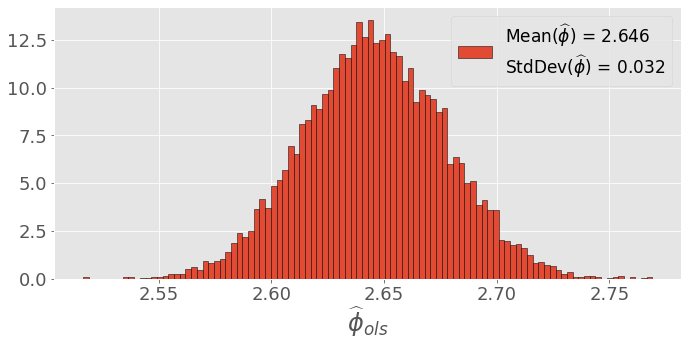

In [34]:
### Plot histogram of OLS coefficients
f = plt.figure(figsize=(10,5))
ols_phi_label = 'Mean$(\widehat\\phi)$ = {:.3f}\nStdDev$(\widehat\\phi)$ = {:.3f}'\
                     .format(np.mean(ols_coefs_model2_AR4[1,:]),np.std(ols_coefs_model2_AR4[1,:])) 
ols_xlabel = '$\widehat\\phi_{ols}$'
plt.hist(ols_coefs_model2_AR4[1,:],bins=100, density=True, edgecolor = "black", label=ols_phi_label)
plt.xlabel(ols_xlabel, fontsize=24)
ymin, ymax = plt.ylim()
asy_mean = phi1_model2
#plt.plot((asy_mean, asy_mean), (ymin, ymax), 'k--')
plt.legend(fontsize=17)
plt.show()

In [35]:
### Compute ACFs and PACFs for each simulation
Nsims = 10000
Nlags = 15
acfs_model2_AR4 = np.empty((Nlags+1,Nsims))
pacfs_model2_AR4 = np.empty((Nlags+1,Nsims))

for ss in range(Nsims): 

    ### Run OLS (with constant)
    _acfs = calc_acf_ols(ols_resid_model2_AR4[:,ss],nlags=15)
    _pacfs = calc_pacf_ols(ols_resid_model2_AR4[:,ss],nlags=15)
        
    ### Store regression estimates in [Nsims x K] numpy array
    acfs_model2_AR4[:,ss] = _acfs
    pacfs_model2_AR4[:,ss] = _pacfs

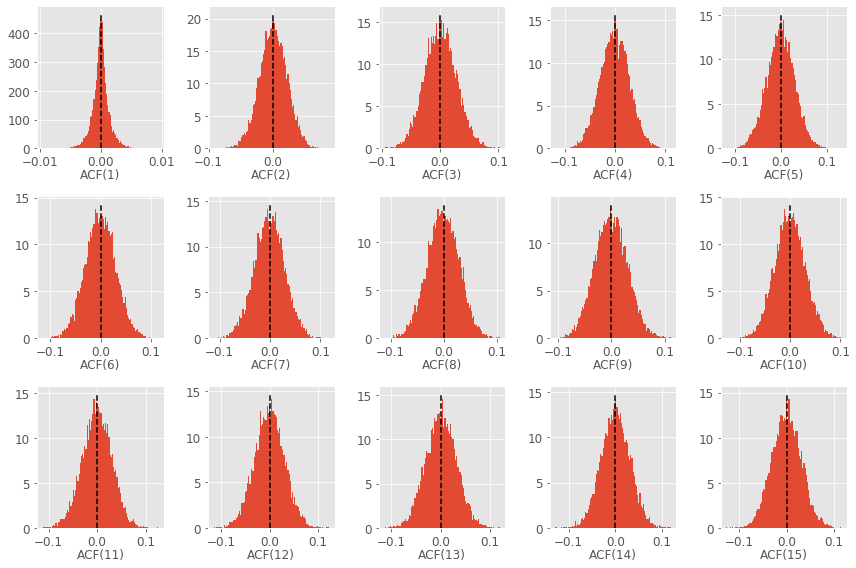

In [36]:
f,a = plt.subplots(nrows=3, ncols=5, figsize=(12,8))

for i in range(0,Nlags):
    a[i//5,i%5].hist(acfs_model2_AR4[i+1,:],bins=100, density=True)
    ymin, ymax = a[i//5,i%5].get_ylim()
    a[i//5,i%5].plot((0,0), (ymin, ymax), 'k--')
    a[i//5,i%5].set_xlabel('ACF('+str(i+1)+')', fontsize = 12)
    a[i//5,i%5].tick_params(labelsize=12)
f.tight_layout()

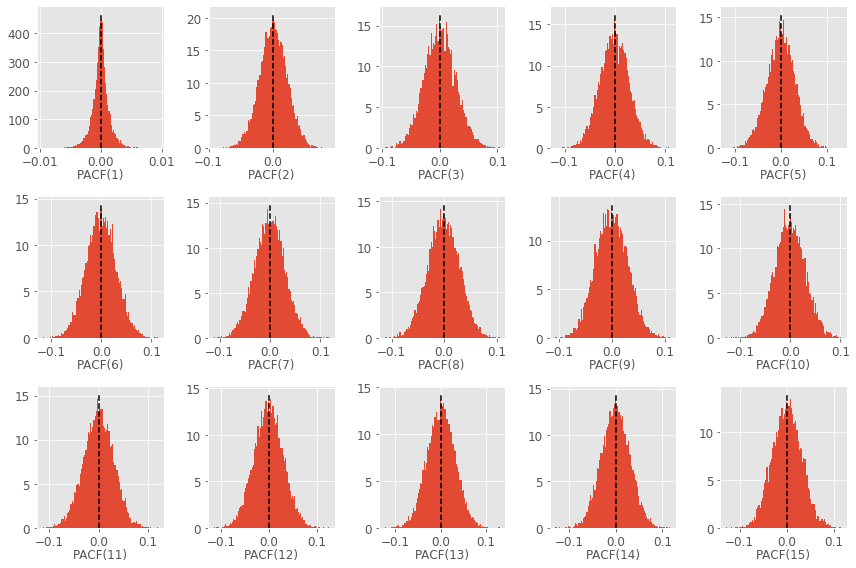

In [37]:
f,a = plt.subplots(nrows=3, ncols=5, figsize=(12,8))

for i in range(0,Nlags):
    a[i//5,i%5].hist(pacfs_model2_AR4[i+1,:],bins=100, density=True)
    ymin, ymax = a[i//5,i%5].get_ylim()
    a[i//5,i%5].plot((0,0), (ymin, ymax), 'k--')
    a[i//5,i%5].set_xlabel('PACF('+str(i+1)+')', fontsize = 12)
    a[i//5,i%5].tick_params(labelsize=12)
f.tight_layout()

## Problem 3

(a)

In [39]:
def simulate_pb3(corr=0,nsample=100, burnin=0, paths=1):
    """ Assumption: White noise shocks are Gaussian.
        Corr is the correlation between x_{1i} and x_{2i}
    """
    
    ### Total number of sample size
    Nsim = nsample + burnin
    
    mean = [0,0]
    cov  = [[1,corr],[corr,1]]
    
    x1   = np.zeros([nsample,paths])
    x2   = np.zeros([nsample,paths])
    y    = np.zeros([nsample,paths])
        
    ### "Standard" Guassian shocks: Normal(0,1)
    for ss in range(paths):
        _X = np.random.multivariate_normal(mean,cov,Nsim)
        _eps = np.random.normal(0,1,Nsim)
        x1[:,ss] = _X[burnin:,0]
        x2[:,ss] = _X[burnin:,1]
        y[:,ss]  = x1[:,ss] + x2[:,ss] + _eps[burnin:]

    return y,x1,x2

In [40]:
### Seed the random number generator
np.random.seed(1)

### Simulate the process
y_pb3,x1_pb3,x2_pb3 =  simulate_pb3(corr=0,burnin=100,nsample=1000,paths=10000)

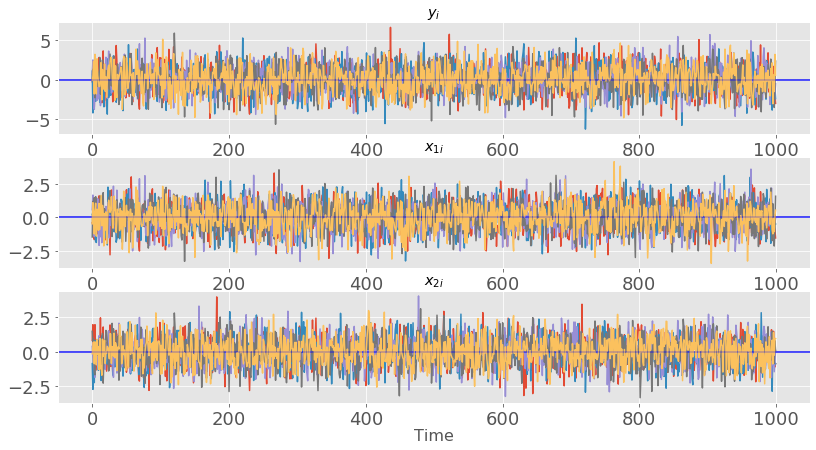

In [41]:
### Plot a few samples to check
f,a = plt.subplots(nrows=3,ncols=1,figsize=(12,7))
n = 5
for i in range(n):
    a[0].plot(y_pb3[:,i])
    a[0].set_title('$y_i$')
    #a[0].set_xlabel('Time', fontsize=16)
    a[0].axhline(y=0, linewidth=0.4)
    a[1].plot(x1_pb3[:,i])
    a[1].set_title('$x_{1i}$')
    #a[1].set_xlabel('Time', fontsize=16)
    a[1].axhline(y=0, linewidth=0.4)
    a[2].plot(x2_pb3[:,i],label='$x_{2i}$')
    a[2].set_title('$x_{2i}$')
    a[2].set_xlabel('Time', fontsize=16)
    a[2].axhline(y=0, linewidth=0.4)
plt.show()

In [42]:
### Estimate coefficient by OLS for each simulation
Nsims = 10000
Nobs = 1000
ols_coefs_model3 = np.empty((2,Nsims))
ols_resid_model3 = np.empty((Nobs,Nsims))

for ss in range(Nsims): 

    ### Run OLS (with constant)
    beta_hat, resids, _ = calc_ols(y_pb3[:,ss],x1_pb3[:,ss],addcon=True)
        
    ### Store regression estimates in [K x Nsims] numpy array
    ols_coefs_model3[:,ss] = beta_hat
    ols_resid_model3[:,ss] = resids

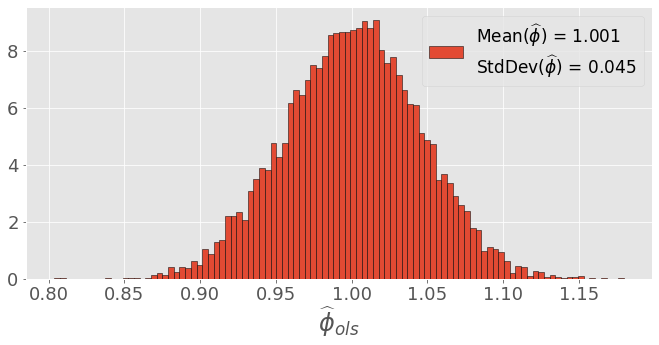

In [43]:
### Plot histogram of OLS coefficients
f = plt.figure(figsize=(10,5))
ols_phi_label = 'Mean$(\widehat\\phi)$ = {:.3f}\nStdDev$(\widehat\\phi)$ = {:.3f}'\
                     .format(np.mean(ols_coefs_model3[1,:]),np.std(ols_coefs_model3[1,:])) 
ols_xlabel = '$\widehat\\phi_{ols}$'
plt.hist(ols_coefs_model3[1,:],bins=100, density=True, edgecolor = "black", label=ols_phi_label)
plt.xlabel(ols_xlabel, fontsize=24)
ymin, ymax = plt.ylim()
asy_mean = phi1_model2
#plt.plot((asy_mean, asy_mean), (ymin, ymax), 'k--')
plt.legend(fontsize=17)
plt.show()

(b)

In [44]:
### Seed the random number generator
np.random.seed(1)

### Simulate the process
y_pb3b,x1_pb3b,x2_pb3b =  simulate_pb3(corr=0.5,burnin=100,nsample=1000,paths=10000)

In [45]:
### Estimate coefficient by OLS for each simulation
Nsims = 10000
Nobs = 1000
ols_coefs_model3b = np.empty((2,Nsims))
ols_resid_model3b = np.empty((Nobs,Nsims))

for ss in range(Nsims): 

    ### Run OLS (with constant)
    beta_hat, resids, _ = calc_ols(y_pb3b[:,ss],x1_pb3b[:,ss],addcon=True)
        
    ### Store regression estimates in [K x Nsims] numpy array
    ols_coefs_model3b[:,ss] = beta_hat
    ols_resid_model3b[:,ss] = resids

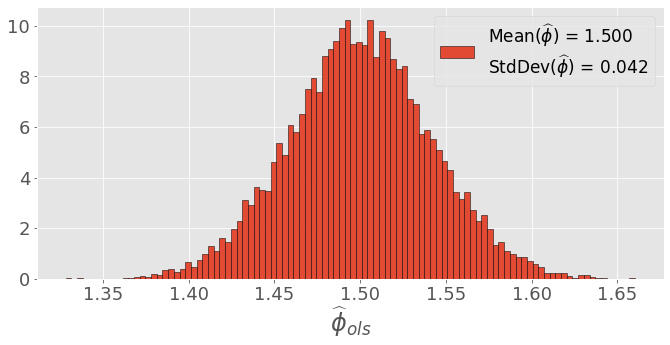

In [46]:
### Plot histogram of OLS coefficients
f = plt.figure(figsize=(10,5))
ols_phi_label = 'Mean$(\widehat\\phi)$ = {:.3f}\nStdDev$(\widehat\\phi)$ = {:.3f}'\
                     .format(np.mean(ols_coefs_model3b[1,:]),np.std(ols_coefs_model3b[1,:])) 
ols_xlabel = '$\widehat\\phi_{ols}$'
plt.hist(ols_coefs_model3b[1,:],bins=100, density=True, edgecolor = "black", label=ols_phi_label)
plt.xlabel(ols_xlabel, fontsize=24)
ymin, ymax = plt.ylim()
asy_mean = phi1_model2
#plt.plot((asy_mean, asy_mean), (ymin, ymax), 'k--')
plt.legend(fontsize=17)
plt.show()

(c)

In [47]:
### Seed the random number generator
np.random.seed(1)

### Simulate the process
y_pb3c,x1_pb3c,x2_pb3c =  simulate_pb3(corr=-0.5,burnin=100,nsample=1000,paths=10000)

In [48]:
### Estimate coefficient by OLS for each simulation
Nsims = 10000
Nobs = 1000
ols_coefs_model3c = np.empty((2,Nsims))
ols_resid_model3c = np.empty((Nobs,Nsims))

for ss in range(Nsims): 

    ### Run OLS (with constant)
    beta_hat, resids, _ = calc_ols(y_pb3c[:,ss],x1_pb3c[:,ss],addcon=True)
        
    ### Store regression estimates in [K x Nsims] numpy array
    ols_coefs_model3c[:,ss] = beta_hat
    ols_resid_model3c[:,ss] = resids

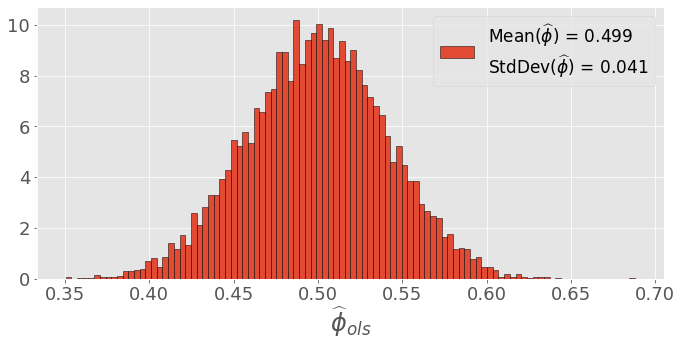

In [49]:
### Plot histogram of OLS coefficients
f = plt.figure(figsize=(10,5))
ols_phi_label = 'Mean$(\widehat\\phi)$ = {:.3f}\nStdDev$(\widehat\\phi)$ = {:.3f}'\
                     .format(np.mean(ols_coefs_model3c[1,:]),np.std(ols_coefs_model3c[1,:])) 
ols_xlabel = '$\widehat\\phi_{ols}$'
plt.hist(ols_coefs_model3c[1,:],bins=100, density=True, edgecolor = "black", label=ols_phi_label)
plt.xlabel(ols_xlabel, fontsize=24)
ymin, ymax = plt.ylim()
asy_mean = phi1_model2
#plt.plot((asy_mean, asy_mean), (ymin, ymax), 'k--')
plt.legend(fontsize=17)
plt.show()

## Problem 4

Cf. solutions.

## Problem 5

(a) Cf. solutions.

(b)(c)

In [50]:
### Seed the random number generator
np.random.seed(12345)

### Simulate MA(1)
theta1_model5 = 0.5
mu_model5 = 1
z_ma1_model5 = simulate_arma(ma=[theta1_model5], burnin=100, nsample=100,paths=1)
z_ma1_model5 = z_ma1_model5 + mu_model5

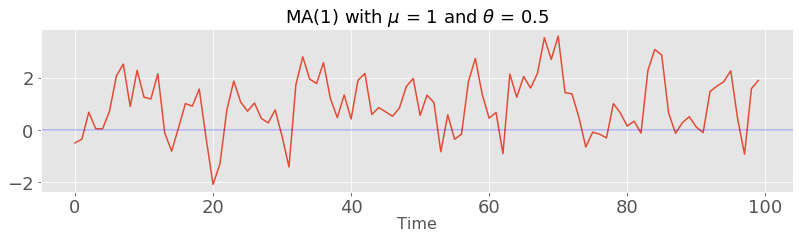

In [51]:
### Plot the sample to check
f = plt.figure(figsize=(12,3))
plt.plot(z_ma1_model5[:,0])
plt.xlabel('Time', fontsize=16)
plt.title('MA($1$)' + ' with $\mu$ = ' + str(mu_model5) + r' and $\theta$ = ' + str(theta1_model5), fontsize=18)
plt.axhline(y=0, linewidth=0.4)
plt.show()

In [52]:
### Define the log-likelihood for an MA(1) process
def logL(z, e0, mu, theta, sigma):
    T    = len(z)
    e    = np.zeros(T)
    e[0] = e0
    for t in range(1,T):
        e[t] = z[t] - mu - theta*e[t-1]
    logL = - (T/2)*np.log(2*np.pi) - (T/2)*np.log(sigma**2) - (1/(2*sigma**2))*np.sum([et**2 for et in e[1:]])
    return(logL)

In [53]:
### Function to minimize (3-dimensional)
fun = lambda omega: -logL(z_ma1_model5, 0, omega[0], omega[1], omega[2])

In [54]:
### Perform the minimization
res = scipy.optimize.minimize(fun,[0.5,0.5,0.5])

### Obtain the standard errors, which are nothing but the diagonal element of the Hessian obtained from scipy
std = np.sqrt(np.diag(res.hess_inv))

### Display results
print('MLE results:')
print("mu: "+str(res['x'][0])+ " (std: "+ str(std[0]) +")")
print("theta: "+str(res['x'][1])+ " (std: "+ str(std[1]) +")")
print("sigma: "+str(res['x'][2])+ " (std: "+ str(std[2]) +")")

MLE results:
mu: 0.9468134605092868 (std: 0.1481990710048885)
theta: 0.5349890593409107 (std: 0.09335578698078233)
sigma: 0.9628555027263147 (std: 0.06821044659788915)


(d)

In [55]:
### Estimate the parameters using statsmodel (which uses Conditional Sum of Square-MLE, by default)
mod = tsa.arima_model.ARMA(z_ma1_model5, order=(0, 1))
res = mod.fit()
print(res.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  100
Model:                     ARMA(0, 1)   Log Likelihood                -138.191
Method:                       css-mle   S.D. of innovations              0.962
Date:                Tue, 21 Apr 2020   AIC                            282.382
Time:                        22:07:32   BIC                            290.198
Sample:                             0   HQIC                           285.546
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9432      0.149      6.331      0.000       0.651       1.235
ma.L1.y        0.5544      0.093      5.936      0.000       0.371       0.737
                                    Roots           

A few notes:
- Our results are very close to those obtained from statsmodel, which is good news.
- Note that in small sample, things can sometimes go astray (e.g. the mean can be quite off).
- One can also estimate $e_0$ instead of setting to 0 here. It makes little difference here, but in general, it can matter, in particular for small samples. For more details, cf. Hamilton (1994).